## Demo: Stage1 processing for mooring data

**Stage 1 Overview**: This is the first processing stage that converts raw instrument files into standardized CF-compliant NetCDF format. It handles multiple instrument types using the `ctd_tools` library for reading and the oceanarray framework for metadata management.

### What Stage1 Does:
- **File Conversion**: Reads raw instrument files (SeaBird, RBR, Nortek, etc.) and converts to NetCDF
- **Standardization**: Applies CF conventions for variable names, units, and metadata
- **Format Preservation**: Preserves original data values without modification or filtering
- **Metadata Enrichment**: Adds deployment information from YAML configuration files
- **Organization**: Outputs files organized by instrument type in the processed directory

### Input Files:
- Raw instrument data files (various formats: `.cnv`, `.rsk`, `.dat`, `.mat`)
- YAML configuration files specifying mooring and instrument metadata

### Output Files:
- Standardized NetCDF files: `{mooring}_{serial}_raw.nc`
- Processing log files for debugging and quality assurance

### Processing Flow:
1. Raw files → ctd_tools readers → xarray.Dataset
2. Apply CF conventions and metadata from YAML
3. Preserve all original data values unchanged
4. Save as NetCDF with standardized naming

**Note**: Stage1 focuses purely on format conversion with no data modification. All processing (filtering, clock corrections, quality control, trimming) happens in Stage2 and subsequent stages.

This notebook demonstrates the usage of the refactored `oceanarray.stage1` module.

In [18]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

# For testing individual readers (optional)
from seasenselib.readers import NortekAsciiReader, AdcpMatlabRdadcpReader, SbeCnvReader,RbrRskAutoReader
from seasenselib.plotters import TimeSeriesPlotter

## Configuration

Set up the base directory and mooring lists for processing.

In [19]:
# Base directory containing the mooring data
basedir = '../examples/'

# Define mooring lists
single_test = ['dsE_1_2018']

# Choose which set to process
moorlist = single_test

print(f"Base directory: {basedir}")
print(f"Processing {len(moorlist)} moorings: {moorlist}")

Base directory: ../examples/
Processing 1 moorings: ['dsE_1_2018']


## Testing Individual Readers

Test reading specific instrument files directly to debug issues.

Data file: ../examples/moor/raw/msm76_2018/aquadopp/DSC18_477102.dat
Header file: ../examples/moor/raw/msm76_2018/aquadopp/DSC18_477102.hdr
Files exist: data=True, header=True

Dataset loaded successfully!
Variables: ['Month', 'Day', 'Year', 'Hour', 'Minute', 'Second', 'Error code', 'Status code', 'east_velocity', 'north_velocity', 'up_velocity', 'east_amplitude', 'north_amplitude', 'up_amplitude', 'Battery voltage', 'speed_of_sound', 'Soundspeed used', 'Heading', 'Pitch', 'Roll', 'pressure', 'Pressure_1', 'temperature', 'Analog input 1', 'Analog input 2', 'Speed', 'Direction']
Time range: 2018-08-12T12:00:00.000000000 to 2018-08-26T17:02:00.000000000


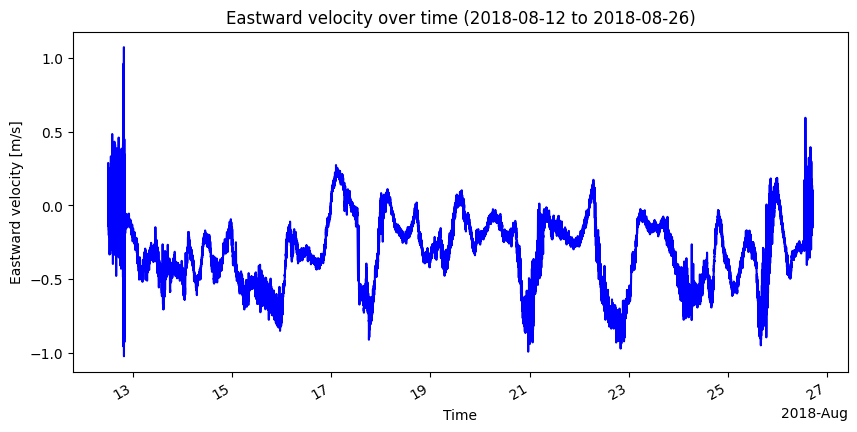

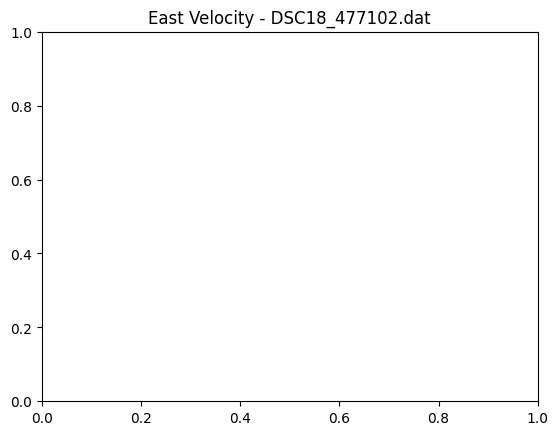

<xarray.Dataset> Size: 5MB
Dimensions:          (time: 20462)
Coordinates:
  * time             (time) datetime64[ns] 164kB 2018-08-12T12:00:00 ... 2018...
Data variables: (12/27)
    Month            (time) int64 164kB 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    Day              (time) int64 164kB 12 12 12 12 12 12 ... 26 26 26 26 26 26
    Year             (time) int64 164kB 2018 2018 2018 2018 ... 2018 2018 2018
    Hour             (time) int64 164kB 12 12 12 12 12 12 ... 16 16 16 17 17 17
    Minute           (time) int64 164kB 0 1 2 3 4 5 6 7 ... 55 56 57 58 59 0 1 2
    Second           (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ...               ...
    Pressure_1       (time) float64 164kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temperature      (time) float64 164kB 19.95 19.96 19.96 ... 18.77 18.79
    Analog input 1   (time) int64 164kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    Analog input 2   (time) int64 164kB 15212 15212 15212 ... 15179 15179 15180
    Speed            (time) float64 164kB 0.18 0.288 0.091 ... 0.134 0.105 0.151
    Direction        (time) float64 164kB 38.46 89.2 16.64 ... 264.8 99.28 143.9

In [15]:
# Test reading a Nortek AquaDopp file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'aquadopp'
    data_dir = rawdir / instrument
    fname = 'DSC18_477102.dat'
    filename = data_dir / fname
    header_file = data_dir / (fname[:-4] + '.hdr')

    print(f"Data file: {filename}")
    print(f"Header file: {header_file}")
    print(f"Files exist: data={filename.exists()}, header={header_file.exists()}")

    if filename.exists() and header_file.exists():
        reader = NortekAsciiReader(str(filename), header_file_path=str(header_file))
        dataset = reader.get_data()

        print(f"\nDataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot if east_velocity exists
        if 'east_velocity' in dataset.data_vars:
            plotter = TimeSeriesPlotter(dataset)
            plotter.plot(parameter_name='east_velocity')
            plt.title(f'East Velocity - {fname}')
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("Files not found - skipping test")

except Exception as e:
    print(f"Error testing Nortek reader: {e}")

ADCP file: ../examples/moor/raw/msm76_2018/adcp/DS0218_RDI_000_24289.mat
File exists: True

ADCP Dataset loaded successfully!
Variables: ['east_velocity', 'north_velocity', 'up_velocity', 'depth', 'pressure', 'ensemble_number', 'heading', 'pitch', 'roll', 'heading_std', 'pitch_std', 'roll_std', 'temperature', 'salinity', 'pressure_std', 'correlation_magnitude', 'echo_intensity', 'status', 'percent_good', 'bt_range', 'bt_velocity', 'bt_correlation', 'bt_amplitude', 'bt_percent_good']
Time range: 2018-08-15T17:00:06.760004909 to 2019-08-10T18:24:06.759996189


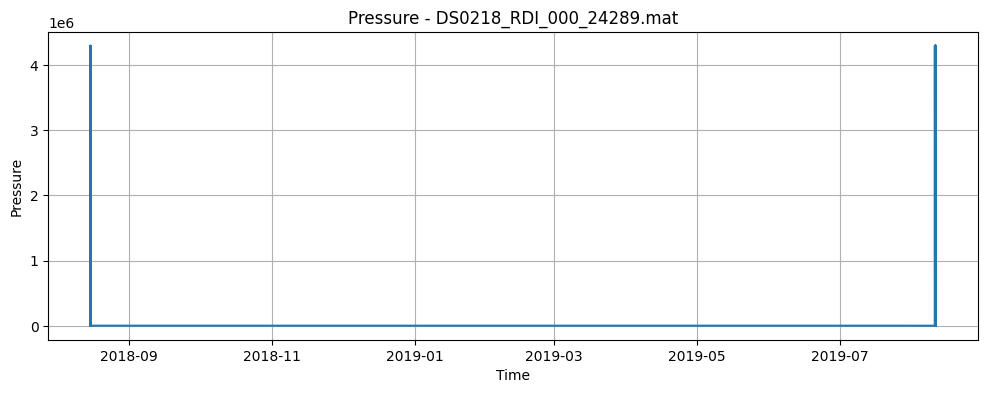

<xarray.Dataset> Size: 1GB
Dimensions:                (bin: 40, time: 172829, beam: 4)
Coordinates:
  * bin                    (bin) int64 320B 1 2 3 4 5 6 7 ... 35 36 37 38 39 40
  * time                   (time) datetime64[ns] 1MB 2018-08-15T17:00:06.7600...
    range                  (bin) float64 320B 12.17 20.17 28.17 ... 316.2 324.2
    z                      (bin, time) float64 55MB 11.17 10.17 ... 322.4 323.3
Dimensions without coordinates: beam
Data variables: (12/24)
    east_velocity          (bin, time) float64 55MB 0.002 0.015 ... nan nan
    north_velocity         (bin, time) float64 55MB 0.037 0.024 ... nan nan
    up_velocity            (bin, time) float64 55MB -0.244 -0.293 ... nan nan
    depth                  (time) float64 1MB 1.0 2.0 1.6 1.9 ... 0.8 1.8 0.9
    pressure               (time) float64 1MB 0.923 2.06 0.464 ... 1.183 0.115
    ensemble_number        (time) float64 1MB 1.0 2.0 ... 1.728e+05 1.728e+05
    ...                     ...
    percent_good           (bin, beam, time) float64 221MB 100.0 100.0 ... 0.0
    bt_range               (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_velocity            (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_correlation         (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_amplitude           (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bt_percent_good        (beam, time) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/21)
    Conventions:                            CF-1.8
    title:                                  ADCP (RDI/Teledyne Workhorse) tim...
    source:                                 ADCP MATLAB export (adcp struct)
    instrument_type:                        wh-adcp
    beam_angle:                             20.0
    beam_frequency_kHz:                     150.0
    ...                                     ...
    ranges_definition:                      cell center range from transducer...
    time_coverage_start:                    2018-08-15T17:00:06.760
    time_coverage_end:                      2019-08-10T18:24:06.759
    vertical_velocity_converted_from_cm_s:  false
    pressure_original_units:                Pa
    dropped_zero_mtime_samples:             1

In [16]:
# Test reading an ADCP MATLAB file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'adcp'
    data_dir = rawdir / instrument
    fname = 'DS0218_RDI_000_24289.mat'
    filename = data_dir / fname

    print(f"ADCP file: {filename}")
    print(f"File exists: {filename.exists()}")

    if filename.exists():
        reader = AdcpMatlabRdadcpReader(str(filename))
        dataset = reader.get_data()

        print(f"\nADCP Dataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot pressure if it exists
        if 'pressure' in dataset.data_vars:
            plt.figure(figsize=(12, 4))
            plt.plot(dataset.time, dataset.pressure)
            plt.title(f'Pressure - {fname}')
            plt.xlabel('Time')
            plt.ylabel('Pressure')
            plt.grid(True)
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("File not found - skipping test")

except Exception as e:
    print(f"Error testing ADCP reader: {e}")

## Analyzing Processed Results

Load and visualize the processed NetCDF files.

Microcat file: ../examples/moor/raw/msm76_2018/microcat/DSE18_SBE37SM_RS232_03707518_2018_08_26.cnv
File exists: True


INFO:pycnv: Opening file: ../examples/moor/raw/msm76_2018/microcat/DSE18_SBE37SM_RS232_03707518_2018_08_26.cnv
INFO:pycnv:Dates computed based on start_date and time_interval


Date
Computing date

Microcat Dataset loaded successfully!
Variables: ['conductivity', 'flag', 'julian_days_offset', 'pressure', 'salinity', 'scan', 'temperature', 'depth', 'density', 'potential_temperature']
Time range: 2018-08-12T08:00:01.000000000 to 2018-08-26T18:09:41.000000000


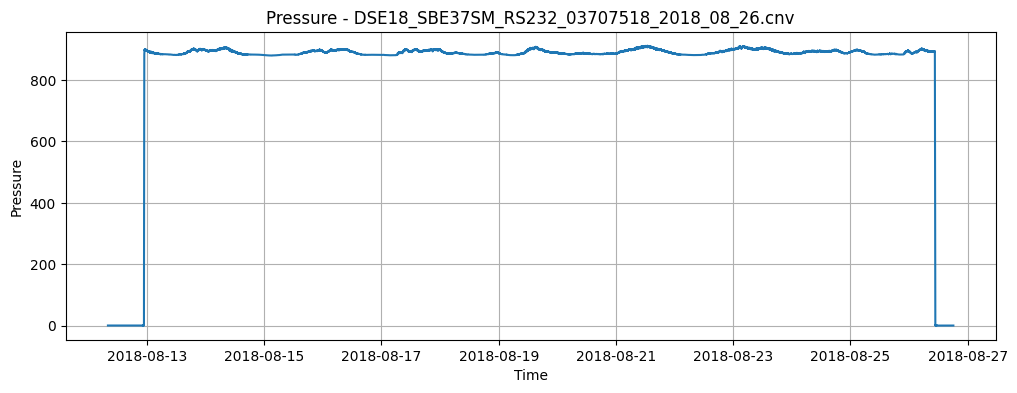

<xarray.Dataset> Size: 11MB
Dimensions:                (time: 124619)
Coordinates:
  * time                   (time) datetime64[ns] 997kB 2018-08-12T08:00:01 .....
    latitude               float64 8B nan
    longitude              float64 8B nan
Data variables:
    conductivity           (time) float64 997kB 0.01248 0.01245 ... 0.01272
    flag                   (time) float64 997kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    julian_days_offset     (time) float64 997kB 224.3 224.3 ... 238.8 238.8
    pressure               (time) float64 997kB 0.065 0.065 ... -0.028 -0.021
    salinity               (time) float64 997kB 0.0139 0.0139 ... 0.0141 0.0141
    scan                   (time) float64 997kB 1.0 2.0 ... 1.246e+05 1.246e+05
    temperature            (time) float64 997kB 20.22 20.22 ... 20.68 20.69
    depth                  (time) float64 997kB nan nan nan nan ... nan nan nan
    density                (time) float64 997kB 998.4 998.4 ... 998.3 998.3
    potential_temperature  (time) float64 997kB 20.22 20.22 ... 20.68 20.69
Attributes: (12/20)
    latitude:                   nan
    longitude:                  nan
    CreateTime:                 2025-10-14T07:55:29
    DataType:                   TimeSeries
    cnv_sbe_model:              SBE 37SM-RS232
    cnv_software_version:       SeatermV2 2.5.0.153
    ...                         ...
    processor_name:             seasenselib
    processor_version:          0.2.0
    processor_reader_class:     SbeCnvReader
    processor_python_version:   3.11.7
    processor_input_filename:   ../examples/moor/raw/msm76_2018/microcat/DSE1...
    processor_input_file_type:  SeaBird CNV

In [17]:
# Test reading an microCAT file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'microcat'
    data_dir = rawdir / instrument
    fname = 'DSE18_SBE37SM_RS232_03707518_2018_08_26.cnv'
    filename = data_dir / fname

    print(f"Microcat file: {filename}")
    print(f"File exists: {filename.exists()}")

    if filename.exists():
        reader = SbeCnvReader(str(filename))
        dataset = reader.get_data()

        print(f"\nMicrocat Dataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot pressure if it exists
        if 'pressure' in dataset.data_vars:
            plt.figure(figsize=(12, 4))
            plt.plot(dataset.time, dataset.pressure)
            plt.title(f'Pressure - {fname}')
            plt.xlabel('Time')
            plt.ylabel('Pressure')
            plt.grid(True)
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("File not found - skipping test")

except Exception as e:
    print(f"Error testing ADCP reader: {e}")

RBR Solo file: ../examples/moor/raw/msm76_2018/rbrsolo/DSE18_101647_20180827_1551.rsk
File exists: True

RBR Solo Dataset loaded successfully!
Variables: ['datasetID', 'temperature']
Time range: 2018-08-12T12:00:00.000000000 to 2018-08-27T15:51:00.000000000


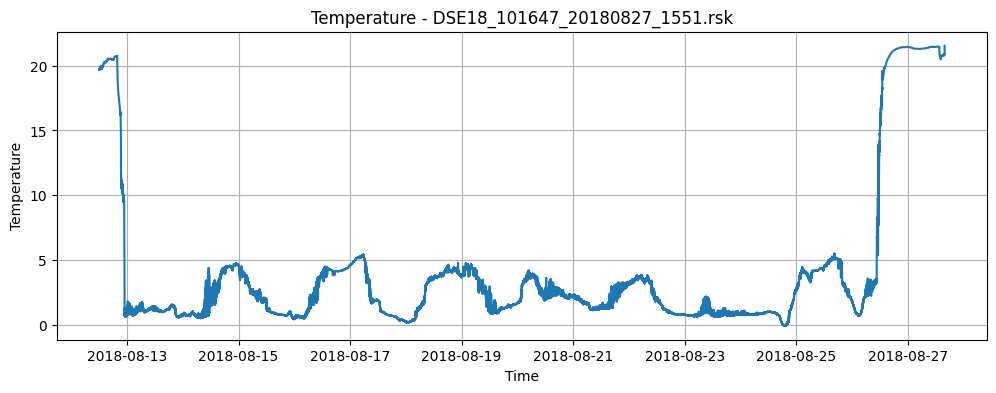

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 130987)
Coordinates:
  * time         (time) datetime64[ns] 1MB 2018-08-12T12:00:00 ... 2018-08-27...
Data variables:
    datasetID    (time) int64 1MB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    temperature  (time) float64 1MB 19.66 19.66 19.66 19.66 ... 21.4 21.44 21.53
Attributes: (12/14)
    instrument_model:             RBRsolo
    instrument_serial:            101647
    instrument_firmware_version:  1.0
    instrument_firmware_type:     9
    rsk_version:                  1.13.4
    rsk_type:                     full
    ...                           ...
    processor_name:               seasenselib
    processor_version:            0.2.0
    processor_reader_class:       RbrRskLegacyReader
    processor_python_version:     3.11.7
    processor_input_filename:     ../examples/moor/raw/msm76_2018/rbrsolo/DSE...
    processor_input_file_type:    RBR RSK Legacy

In [21]:
# Test reading an rbrsolo file directly
try:
    rawdir = Path(basedir) / 'moor/raw/msm76_2018/'
    instrument = 'rbrsolo'
    data_dir = rawdir / instrument
    fname = 'DSE18_101647_20180827_1551.rsk'
    filename = data_dir / fname

    print(f"RBR Solo file: {filename}")
    print(f"File exists: {filename.exists()}")

    if filename.exists():
        reader = RbrRskAutoReader(str(filename))
        dataset = reader.get_data()

        print(f"\nRBR Solo Dataset loaded successfully!")
        print(f"Variables: {list(dataset.data_vars)}")
        print(f"Time range: {dataset.time.min().values} to {dataset.time.max().values}")

        # Plot temperature if it exists
        if 'temperature' in dataset.data_vars:
            plt.figure(figsize=(12, 4))
            plt.plot(dataset.time, dataset.temperature)
            plt.title(f'Temperature - {fname}')
            plt.xlabel('Time')
            plt.ylabel('Temperature')
            plt.grid(True)
            plt.show()

        # Display dataset info
        display(dataset)
    else:
        print("File not found - skipping test")

except Exception as e:
    print(f"Error testing RBR Solo reader: {e}")